# Delta Calculation Maps

In [1]:
import xarray as xr
import xoak
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import geopandas as gpd
import regionmask
import cartopy
import cartopy.crs as ccrs
import glob
from copy import deepcopy

In [2]:
from matplotlib.colors import ListedColormap, BoundaryNorm


def div_colorbar():
    
    div_colors = ['#053061',
                  '#2166ac',
                  '#4393c3',
                  '#92c5de',
                  '#d1e5f0',
                  '#f7f7f7',
                  '#fddbc7',
                  '#f4a582',
                  '#d6604d',
                  '#b2182b',
                  '#67001f'
                  ]
    
    cmap = ListedColormap(div_colors)
    
    return cmap

def div_boundarynorm():
    
    
    cmap = div_colorbar()
    classes = np.array(list(np.linspace(-5, 5, num=11)))
    norm = BoundaryNorm(classes, ncolors=cmap.N) 
    
    return cmap, norm

cmap, norm = div_boundarynorm()

### Load Data

In [3]:
#load wrf-bcc dataframes
df_HIST = pd.read_csv(f'/home/scratch/jcorner1/syn_sev/dataframes/HIST_UVV_REFC_regrid_threshold_dataframe.csv')
df_8p5EOC = pd.concat(map(pd.read_csv, glob.glob('/home/scratch/jcorner1/syn_sev/dataframes/EOC8p5_UVV*')), ignore_index=True)
df_4p5EOC = pd.concat(map(pd.read_csv, glob.glob('/home/scratch/jcorner1/syn_sev/dataframes/EOC4p5_UVV*')), ignore_index=True)
df_8p5MID = pd.concat(map(pd.read_csv, glob.glob('/home/scratch/jcorner1/syn_sev/dataframes/MC8p5_UVV*')), ignore_index=True)
df_4p5MID = pd.concat(map(pd.read_csv, glob.glob('/home/scratch/jcorner1/syn_sev/dataframes/MC4p5_UVV*')), ignore_index=True)

#iterate through the epochs and threshold each based on UVV value
epochs = ['HIST', '4p5MID', '8p5MID', '8p5EOC', '4p5EOC']

for epoch in epochs:
    locals()[f'df_{epoch}'] = locals()[f'df_{epoch}'][((locals()[f'df_{epoch}']['DBZ'] >= 40.0) & (locals()[f'df_{epoch}']['UVV'] >= 25.0))]
    locals()[f'df_{epoch}']['Time'] = pd.to_datetime( locals()[f'df_{epoch}']['Time'])

In [4]:
#iterate through each epoch
for epoch in epochs:
    geog = xr.open_dataset("/home/scratch/WRF_BCC/geography/geo_em.d01.nc")
    print(epoch)
    df_wrf = locals()[f'df_{epoch}']
    uhs = []

    #iterate through each
    for did, day in df_wrf.resample('24h', origin='1990-10-01 12:00:00', on='Time'):
    
        results = np.zeros(shape=(899, 1399))
        results[day.y.values.astype(int), day.x.values.astype(int)] = 1
        uh_uvv = deepcopy(geog)
        uh_uvv = uh_uvv.assign_coords({'Time': np.array([did])})
        uh_uvv = uh_uvv.assign(UVV_DAYS = (('Time', 'south_north', 'west_east'), np.expand_dims(results, axis=0)))
        uh_uvv = uh_uvv[['CLAT', 'CLONG', 'UVV_DAYS']].coarsen(south_north=20, west_east=20, boundary='trim').mean()
        uh_uvv['UVV_DAYS'] = 1*(uh_uvv['UVV_DAYS'] > 0)

        uhs.append(uh_uvv)

    locals()[f'uhs_{epoch}'] = xr.concat(uhs, dim='Time')
    
    if epoch != 'HIST':
        locals()[f'delta_{epoch}'] = (np.sum(locals()[f'uhs_{epoch}'].UVV_DAYS.values, axis=0) - np.sum(uhs_HIST.UVV_DAYS.values, axis=0)) / 15

HIST
4p5MID
8p5MID
8p5EOC
4p5EOC


/tmp/ipykernel_20065/3839374720.py:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(2, 2, i+1, projection=ccrs.LambertConformal(central_longitude=-98, central_latitude=35))


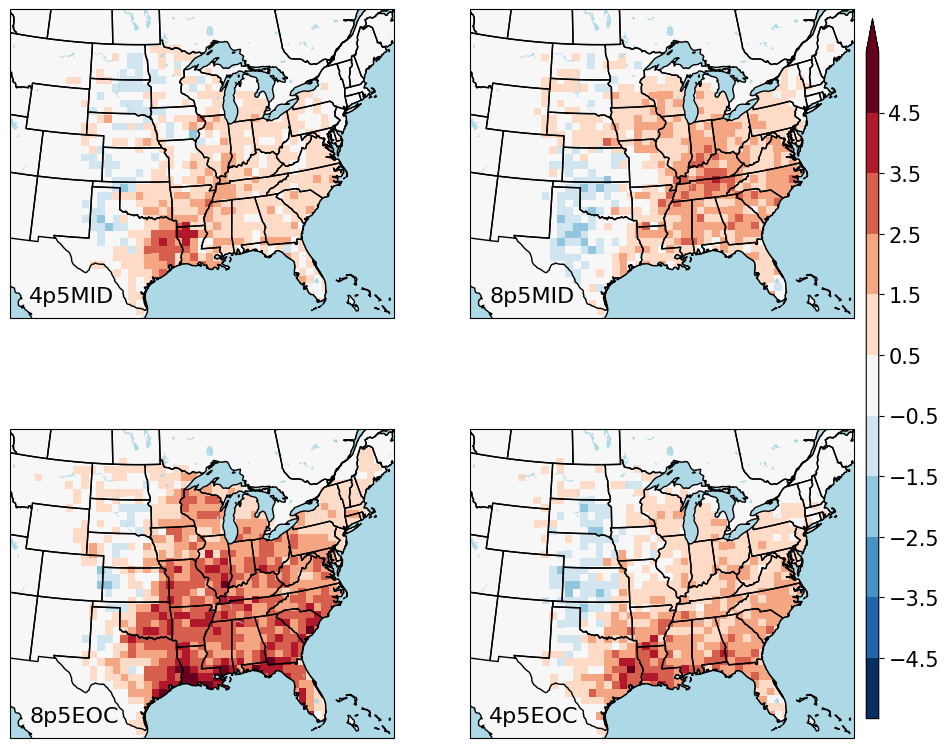

In [8]:
#Plot the data
fig = plt.figure(figsize=(12.5,10))
plt.tick_params(left = False, right = False , labelleft = False ,
                    labelbottom = False, bottom = False)

divnorm=colors.TwoSlopeNorm(vmin=-5.5, vcenter=0., vmax=5.5)

plt.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, 0.15, 0.01, 0.7])

for i in range(len(epochs[1:])):

    ax = plt.subplot(2, 2, i+1, projection=ccrs.LambertConformal(central_longitude=-98, central_latitude=35))
    c = ax.pcolormesh(uhs_HIST.CLONG.values[0,:,:], uhs_HIST.CLAT.values[0,:,:],locals()[f'delta_{epochs[1:][i]}'],
                      transform=cartopy.crs.PlateCarree(), cmap=cmap, norm=divnorm)
    
    ax.add_feature(cartopy.feature.STATES, zorder=2)
    ax.add_feature(cartopy.feature.COASTLINE, zorder=3)
    ax.add_feature(cartopy.feature.LAND, facecolor='white')
    ax.add_feature(cartopy.feature.OCEAN, facecolor='lightblue', zorder=2)
    ax.add_feature(cartopy.feature.LAKES, facecolor='lightblue')

    ax.set_extent([-110, -74, 24.5, 50])

    ax.annotate(f'{epochs[1:][i]}', (0.05,0.05),fontsize=16, xycoords='axes fraction')
    
cbar = plt.colorbar(c,ticks=np.array(range(-5, 5, 1))+0.5, pad=0.01, extend='max', ax=ax, cax=cbar_ax)
cbar.ax.tick_params(labelsize=15)
plt.show()